Imports

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import sys

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import auc
from itertools import cycle

sys.path.append('./evaluacion_multicanal_votacion')
from utils import *

# Cargar modelos

In [2]:
model_v1 = load_model_safely('./modelos/V1/modelo_phase2_3185550174.keras')
model_d2 = load_model_safely('./modelos/Arquitectura compleja con AD/modelo_phase2_192939353.keras')
model_d3 = load_model_safely('./modelos/Lead III/modelo_phase2_3367708436.keras')

Modelo cargado desde ./modelos/V1/modelo_phase2_3185550174.keras
Modelo cargado desde ./modelos/Arquitectura compleja con AD/modelo_phase2_192939353.keras
Modelo cargado desde ./modelos/Lead III/modelo_phase2_3367708436.keras


# Cargar conjunto de imágenes de validación

In [3]:
# Cargar los CSV
rutaCSV = "./BD/ECGData_ScalogramImgSuavizadas_299_299_csv/"
test_df = pd.read_csv(rutaCSV + "ECGData_ScalogramImgSuavizadas_299_299_Test_stratified.csv")

# Separar los canales
test_canales = separar_por_canales(test_df)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    dtype='float32'
)

directorio = './BD/'

test_generator_d2 = test_datagen.flow_from_dataframe(
    dataframe=test_canales[CANALES[0]-1],
    directory=directorio,  
    x_col="Filepath",
    y_col="Label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
test_generator_d3 = test_datagen.flow_from_dataframe(
    dataframe=test_canales[CANALES[1]-1],
    directory=directorio,
    x_col="Filepath",
    y_col="Label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator_v1 = test_datagen.flow_from_dataframe(
    dataframe=test_canales[CANALES[2]-1],
    directory=directorio,  
    x_col="Filepath",
    y_col="Label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2115 validated image filenames belonging to 4 classes.
Found 2115 validated image filenames belonging to 4 classes.
Found 2115 validated image filenames belonging to 4 classes.


# Asegurarse de que cada modelo reciba las imágenes procesadas de forma coherente (todas en el mismo orden)

In [4]:
# Función para extraer el nombre base sin el sufijo final
def extraer_nombre_base(filepath):
    filename = os.path.basename(filepath)
    match = re.match(r"(\d+)_\d+\.png", filename)
    return match.group(1) if match else None

# Obtener los nombres base de cada conjunto
nombres_base_d2 = [extraer_nombre_base(fp) for fp in test_generator_d2.filenames]
nombres_base_d3 = [extraer_nombre_base(fp) for fp in test_generator_d3.filenames]
nombres_base_v1 = [extraer_nombre_base(fp) for fp in test_generator_v1.filenames]

# Comprobar si todas las posiciones coinciden entre listas
coinciden = all(a == b == c for a, b, c in zip(nombres_base_d2, nombres_base_d3, nombres_base_v1))

print("¿Coinciden todos los nombres base (ignorando el número final)?", coinciden)


¿Coinciden todos los nombres base (ignorando el número final)? True


# Predicciones

In [ ]:
preds_v1 = model_v1.predict(test_generator_v1)
preds_d2 = model_d2.predict(test_generator_d2)
preds_d3 = model_d3.predict(test_generator_d3)

# Guardar
np.save('./evaluacion_multicanal_votacion/predicciones_v1.npy', preds_v1)
np.save('./evaluacion_multicanal_votacion/predicciones_d2.npy', preds_d2)
np.save('./evaluacion_multicanal_votacion/predicciones_d3.npy', preds_d3)

17/17 [==============================] - 138s 8s/step


In [ ]:
# Cargar cuando se necesite
preds_v1 = np.load('./evaluacion_multicanal_votacion/predicciones_v1.npy')
preds_d2 = np.load('./evaluacion_multicanal_votacion/predicciones_d2.npy')
preds_d3 = np.load('./evaluacion_multicanal_votacion/predicciones_d3.npy')

# Aplicar la lógica de votación por mayoría
Para cada imagen, se cuenta cuántos modelos votan por cada clase. La clase con más votos es la predicción final.

Si hay empate, se elige la clase que predice el modelo V1 (modelo con mejor rendimiento).

In [ ]:
# Clase predicha por cada modelo
labels_v1 = np.argmax(preds_v1, axis=1)
labels_d2 = np.argmax(preds_d2, axis=1)
labels_d3 = np.argmax(preds_d3, axis=1)

# Aplicar votación mayoritaria con desempate a favor de V1
final_preds = []

for i in range(len(labels_v1)):
    votos = [labels_v1[i], labels_d2[i], labels_d3[i]]
    
    # Contar los votos por clase
    conteo = np.bincount(votos, minlength=4)
    max_votos = np.max(conteo)
    
    # Clases que recibieron el número máximo de votos
    clases_mayoritarias = np.where(conteo == max_votos)[0]

    if len(clases_mayoritarias) == 1:
        final_preds.append(clases_mayoritarias[0])
    else:
        # Empate: elegimos la predicción de V1
        final_preds.append(labels_v1[i])

# Guardar
np.save('./evaluacion_multicanal_votacion/predicciones_finales.npy', final_preds)

In [ ]:
# Cargar cuando se necesite
final_preds = np.load('./evaluacion_multicanal_votacion/predicciones_finales.npy')

# Evaluar predicciones finales

In [7]:
true_labels = test_generator_v1.classes # suponiendo mismo orden

final_preds_prob = (preds_v1 + preds_d2 + preds_d3) / 3

## Métricas

In [8]:
accuracy = accuracy_score(true_labels, final_preds)
precision = precision_score(true_labels, final_preds, average='weighted')
recall = recall_score(true_labels, final_preds, average='weighted')
f1 = f1_score(true_labels, final_preds, average='weighted')

# Aquí se asume que final_preds_prob es la probabilidad promedio de las clases
auc_global = roc_auc_score(true_labels, final_preds_prob, multi_class='ovr')

# Mostrar resultados
print(f"Accuracy: {accuracy * 100:.3f}%")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"AUC: {auc_global:.3f}")

Accuracy: 92.813%
Precision: 0.928
Recall: 0.928
F1-Score: 0.927
AUC: 0.990


### Guardar resultados en excel

In [ ]:
# Crear un DataFrame con los resultados
resultados = pd.DataFrame({
    #'': ['Validación'],
    'Accuracy (%)': [accuracy*100],
    'Precisión': [precision],
    'Sensibilidad': [recall],
    'AUC': [auc_global],
    'F1-Score': [f1]
})

# Guardar el DataFrame en un archivo Excel
ruta_excel = './evaluacion_multicanal_votacion/resultados_votacion.xlsx'
resultados.to_excel(ruta_excel, index=False)

print(f"📁 Resultados guardados en: {ruta_excel}")

📁 Resultados guardados en: ./evaluación multicanal votación/resultados_votacion.xlsx


## Curva ROC

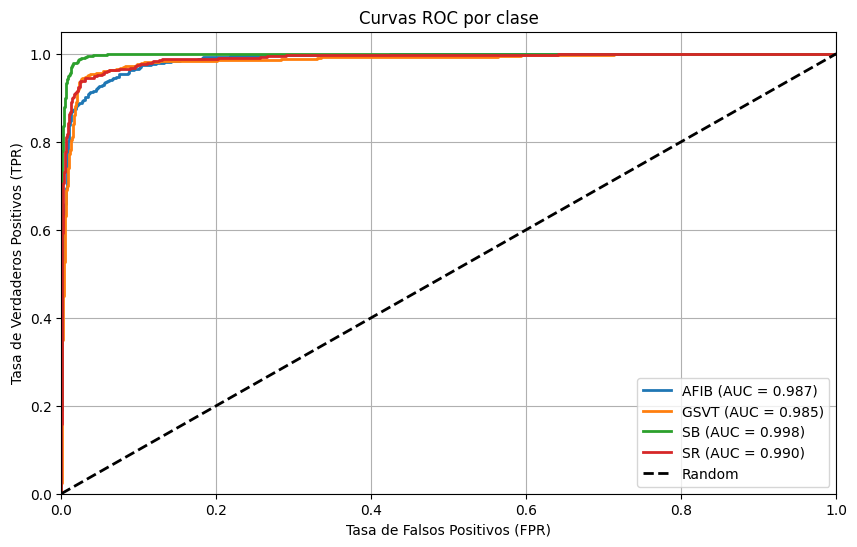

In [8]:
# Convertir las etiquetas reales a formato one-hot (si no lo están ya)
true_labels_onehot = pd.get_dummies(true_labels).values

# Crear una figura para todas las curvas ROC
plt.figure(figsize=(10, 6))

# Trazar una curva ROC por clase
for i, class_name in enumerate(test_generator_v1.class_indices.keys()):
    fpr, tpr, _ = roc_curve(true_labels_onehot[:, i], final_preds_prob[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.3f})')

# Línea de referencia (clasificador aleatorio)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')

# Configuración de la gráfica
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por clase')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Matriz de confusión

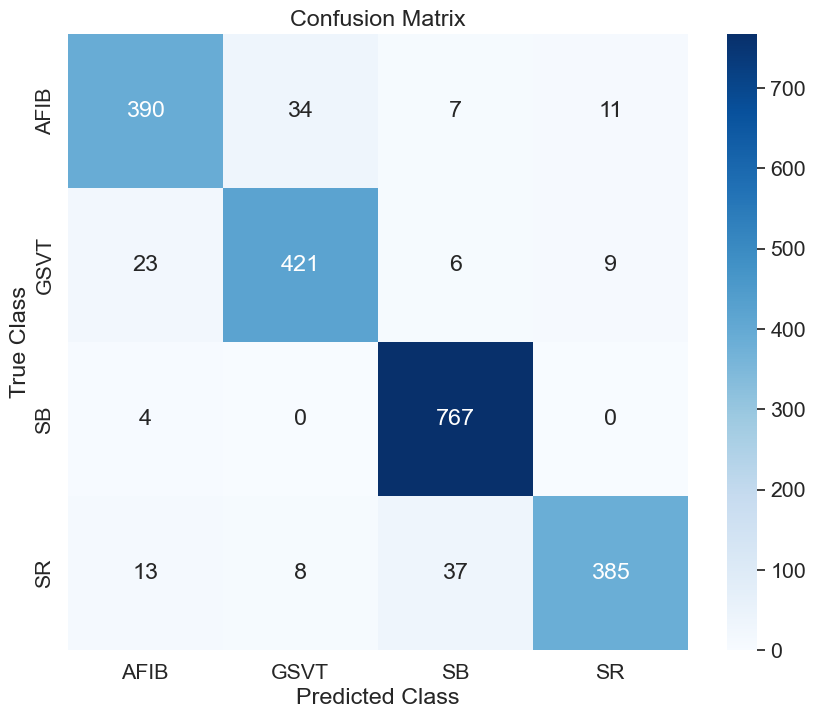

In [11]:
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)  # Aumentar el tamaño de la fuente para la matriz de confusión
cm = confusion_matrix(true_labels, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator_v1.class_indices.keys(), yticklabels=test_generator_v1.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

## Reporte de clasificación

In [12]:
print(classification_report(true_labels, final_preds, target_names=test_generator_v1.class_indices.keys()))

              precision    recall  f1-score   support

        AFIB       0.91      0.88      0.89       442
        GSVT       0.91      0.92      0.91       459
          SB       0.94      0.99      0.97       771
          SR       0.95      0.87      0.91       443

    accuracy                           0.93      2115
   macro avg       0.93      0.92      0.92      2115
weighted avg       0.93      0.93      0.93      2115



## Graficar predicciones y clases verdaderas

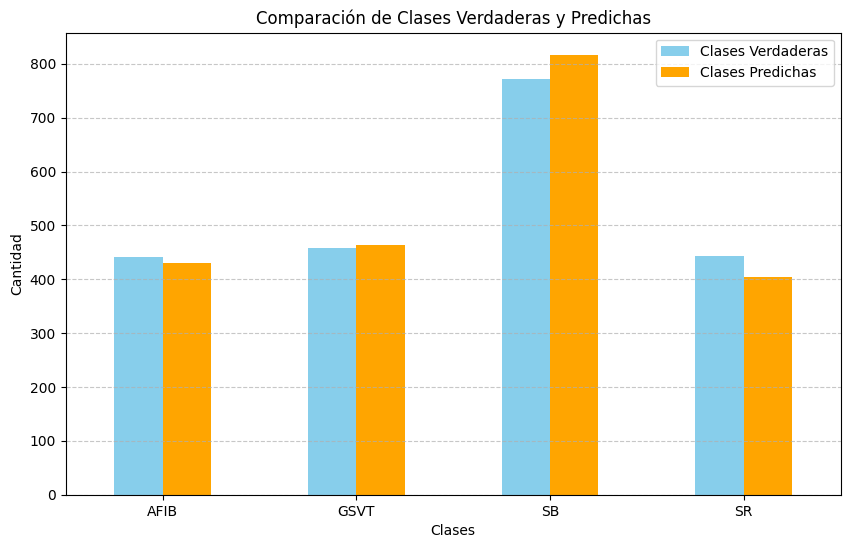

In [13]:
# Contar las clases verdaderas y predichas
true_counts = np.bincount(true_labels, minlength=4)
pred_counts = np.bincount(final_preds, minlength=4)

# Crear un DataFrame para facilitar la visualización
df_comparison = pd.DataFrame({
    'Clases Verdaderas': true_counts,
    'Clases Predichas': pred_counts
}, index=test_generator_v1.class_indices.keys())

# Graficar
df_comparison.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'])
plt.title('Comparación de Clases Verdaderas y Predichas')
plt.xlabel('Clases')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()